In [1]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram, leaves_list
from scipy.spatial.distance import pdist, squareform
from itertools import combinations
import networkx as nx

In [2]:
os.chdir('/tscc/projects/ps-palmer/brittany/SUD_cross_species/')

# import MPO

In [3]:
import obonet as obo
from netcoloc import validation
os.chdir('/tscc/projects/ps-palmer/brittany/ddot')
import ddot
os.chdir('/tscc/projects/ps-palmer/brittany/SUD_cross_species/scripts/')
from network_validation_functions import *
os.chdir('/tscc/projects/ps-palmer/brittany/SUD_cross_species/')

/tscc/nfs/home/bsleger/miniconda3/envs/env-std-py38/lib/python3.8/site-packages/netcoloc/validation.py:20: UserWarning: Import of ddot failed. NetColoc will not work properly: + No module named 'ddot'
  warnings.warn('Import of ddot failed. NetColoc will not work properly: + ' + str(ie))


In [4]:
# load mappings between genes and mammalian phenotypes
mgi_df = validation.load_MGI_mouseKO_data()
print("Number of gene-phenotype associations:", len(mgi_df))
# import table of names of MPO terms
MPO_desc=import_MPO_description()
#import the MPO in graph format
graph = obo.read_obo('http://www.informatics.jax.org/downloads/reports/MPheno_OBO.ontology')
#subset the graph to remove obsolete terms
graph=graph.subgraph(list(set(MPO_desc[~MPO_desc['description'].str.contains('obsolete')].index)))
#get id from name or name from ID 
id_to_name = {id_: data.get('name') for id_, data in graph.nodes(data=True)}
name_to_id = {data['name']: id_ for id_, data in graph.nodes(data=True) if 'name' in data}

33 input query terms found dup hits:	[('Adam1a', 2), ('Betalinc1', 2), ('Cast', 2), ('Chaserr', 2), ('Dnajb3', 2), ('Dnm3os', 2), ('Eldr'
12788 input query terms found no hit:	['+|Cav1', '+|Cm', '+|Del(10Prmt2-Pdxk)4Yey', '+|Del(11Mpo-Chad)18Brd', '+|Del(11Rr325)1Smun', '+|De


26019
13231
13198
Number of gene-phenotype associations: 388898


/tscc/projects/ps-palmer/brittany/ddot/ddot/Ontology.py:394: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  pd.Series(id2namespace).to_csv(id2namespace_file, sep='\t')


15591


In [5]:
par=[id_to_name[x] for x in graph.predecessors('MP:0000001')]

In [6]:
gpt_path='validation_datasets/MGI_genes_per_trait_MP.csv'
if (os.path.isfile(gpt_path)):
    genes_per_trait=pd.read_csv(gpt_path)
    print('reading in file')
else:
    print('calculating genes per trait')
    genes_per_trait=count_genes_per_trait(['MP:0000001'],mgi_df,'human_ortholog','MP',id_to_name,name_to_id,graph)
    genes_per_trait.to_csv(gpt_path,index=False)

reading in file


# import meta data on traits

In [7]:
meta_data=pd.read_csv('gwas_ctrl_hm/ext1_st8_corr_sources_downloaded.csv')

In [8]:
meta_data['Trait 2']=meta_data['Trait 2'].str.replace('*','')

/scratch/bsleger/job_7273511/ipykernel_1049874/3041695061.py:1: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  meta_data['Trait 2']=meta_data['Trait 2'].str.replace('*','')


In [9]:
meta_data['ctrl_type'][20]='positive'

/scratch/bsleger/job_7273511/ipykernel_1049874/792440445.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  meta_data['ctrl_type'][20]='positive'


In [10]:
meta_data['N trait 2']=meta_data['N trait 2'].apply(lambda x: int(x.replace(',','')))

In [11]:
meta_sub=meta_data[['label','ctrl_type','Trait 2','N trait 2','rG']].sort_values('N trait 2')

In [12]:
rm=['antisoc', 'townsend', 'friend_sat', 'neurot','age_smkinit','bmi','height']

In [13]:
meta_sub=meta_data[['label','ctrl_type','Trait 2','N trait 2','rG']].sort_values('N trait 2')

# import files as a table

In [14]:
trait_r='loco_final_cf'
cut_r= 'FDR'
interactome_name='PCNet2.0'
cut_single=1.5
cut_comb=3


In [15]:
os.chdir('/tscc/projects/ps-palmer/brittany/SUD_cross_species/')

In [16]:
subset=f'{trait_r}_{cut_r}_NPS-{cut_single}-{cut_comb}_{interactome_name}_enr.csv'

In [17]:
files=os.listdir('validation_output/')
files=[x for x in files if (('MGI' in x)&(subset in x))]


In [18]:
tbl=pd.DataFrame()
for f in files:
    print(f)
    trait=f[16:(len(f)-45)]
    t=pd.read_csv(f'validation_output/{f}')
    t['human_trait']=trait
    t['human_dataset']=trait.replace('_top500','').replace('_FDR','').replace('_bonf','')
    print(t.columns)
    tbl=pd.concat([tbl,t],axis=0,ignore_index=True)
    print(len(tbl))

MGI_enr_network-bmi_top500-loco_final_cf_FDR_NPS-1.5-3_PCNet2.0_enr.csv
Index(['trait', 'parent_trait', 'community_genes', 'n_community_genes',
       'odds_ratio', 'log_se_or', 'p_intersect', 'depth', 'seed_h', 'seed_r',
       'n_seed_h', 'n_seed_r', 'n_seed', 'human_trait', 'human_dataset'],
      dtype='object')
6813
MGI_enr_network-ext_rtb_bonf-loco_final_cf_FDR_NPS-1.5-3_PCNet2.0_enr.csv
Index(['trait', 'parent_trait', 'community_genes', 'n_community_genes',
       'odds_ratio', 'log_se_or', 'p_intersect', 'depth', 'seed_h', 'seed_r',
       'n_seed_h', 'n_seed_r', 'n_seed', 'human_trait', 'human_dataset'],
      dtype='object')
14407
MGI_enr_network-park_bonf-loco_final_cf_FDR_NPS-1.5-3_PCNet2.0_enr.csv
Index(['trait', 'parent_trait', 'community_genes', 'n_community_genes',
       'odds_ratio', 'log_se_or', 'p_intersect', 'depth', 'seed_h', 'seed_r',
       'n_seed_h', 'n_seed_r', 'n_seed', 'human_trait', 'human_dataset'],
      dtype='object')
20375
MGI_enr_network-maternal_smo

# merge in meta_data

In [19]:
tbl=tbl.merge(meta_data,left_on='human_dataset',right_on='label')

# subset dataset

In [20]:
tbl=tbl.sort_values(['parent_trait','depth'])

In [21]:
tbl=tbl[(tbl['human_trait']!='ext_db_FDR')&(tbl['human_trait']!='ext_rtb_bonf')]

In [22]:
tbl_sub=tbl[['human_trait','trait','Trait 2','odds_ratio','p_intersect']].drop_duplicates()
sigcut=0.05/(len(graph.nodes())*len(set(tbl_sub.human_trait)))

tbl_sub=tbl_sub[tbl.trait.isin(tbl[tbl.p_intersect<sigcut]['trait'])]
tbl_sub['log_odds']=np.log(tbl_sub['odds_ratio'])

/scratch/bsleger/job_7273511/ipykernel_1049874/3910971169.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  tbl_sub=tbl_sub[tbl.trait.isin(tbl[tbl.p_intersect<sigcut]['trait'])]


In [23]:
tbl_sub['trait_full']=tbl_sub.trait
tbl_sub['trait']=tbl_sub.trait.str.replace(' phenotype',' pheno.')
tbl_sub['trait']=tbl_sub.trait.str.replace('abnormal ','abn. ')
tbl_sub['trait']=tbl_sub.trait.str.replace('behavioral','behav.')
tbl_sub['trait']=tbl_sub.trait.str.replace('behavior','behav.')

In [24]:
tbl_sub['MPO']=tbl_sub['trait_full'].apply(lambda x: name_to_id[x])

In [25]:
tbl_sub=tbl_sub[tbl_sub['Trait 2']!='BMI']

# calculate odds and pvalue tables

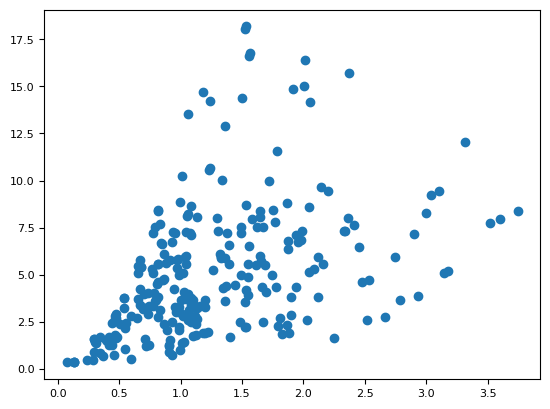

In [42]:
plt.scatter(tbl_sub['log_odds'],-np.log10(tbl_sub['p_intersect']))

In [33]:
odds = tbl_sub.pivot(columns='Trait 2', index='trait', values='log_odds')
odds=odds.fillna(0)
pval = tbl_sub.pivot(columns='Trait 2', index='trait', values='p_intersect')
pval=pval.fillna(1)

row_linkage = linkage(pdist(odds.values), method='ward')
col_linkage = linkage(pdist(odds.values.T), method='ward')

row_order = leaves_list(row_linkage)
col_order = leaves_list(col_linkage)

In [34]:
col_order

array([3, 4, 1, 2, 0, 5], dtype=int32)

# plot

In [35]:
odds_c = odds.iloc[row_order, col_order]
pval_c= pval.iloc[row_order, col_order]
annot_c = pval_c.applymap(lambda p: '*' if p < sigcut else '')

In [36]:
hex=sns.color_palette("RdPu").as_hex()

behav_traits=return_descendents_name(graph,id_to_name,name_to_id['behavior/neurological phenotype'])
nerv_sys_traits=return_descendents_name(graph,id_to_name,name_to_id['nervous system phenotype'])
mpo_groups={
    'nerv':set(tbl_sub[(tbl_sub['trait_full'].isin(nerv_sys_traits))&(~tbl_sub['trait_full'].isin(behav_traits))]['trait']),
    'behav':set(tbl_sub[(tbl_sub['trait_full'].isin(behav_traits))&(~tbl_sub['trait_full'].isin(nerv_sys_traits))]['trait']),
    'nerv_behav':set(tbl_sub[(tbl_sub['trait_full'].isin(behav_traits))&(tbl_sub['trait_full'].isin(nerv_sys_traits))]['trait']),
    'other':set(tbl_sub[(~tbl_sub['trait_full'].isin(nerv_sys_traits))&(~tbl_sub['trait_full'].isin(behav_traits))]['trait'])
}
tbl_sub_dict={
    'nerv':tbl_sub[tbl_sub.trait.isin(mpo_groups['nerv'])],
    'behav':tbl_sub[tbl_sub.trait.isin(mpo_groups['behav'])],
    'nerv_behav':tbl_sub[tbl_sub.trait.isin(mpo_groups['nerv_behav'])]}

trait_color_map = {
    'nerv': '#9e9e9e',
    'behav': 'black',
    'nerv_behav': '#5b5b5b',
    'other': 'yellow'}

def get_trait_color(trait,trait_color_map,mpo_groups):
    for m in mpo_groups.keys():
        if trait in mpo_groups[m]:
            return trait_color_map[m]
ytick_colors = [get_trait_color(trait,trait_color_map,mpo_groups) for trait in odds_c.index]

In [37]:
plt.rcParams.update({'font.size': 8})

In [38]:
save_fig=False

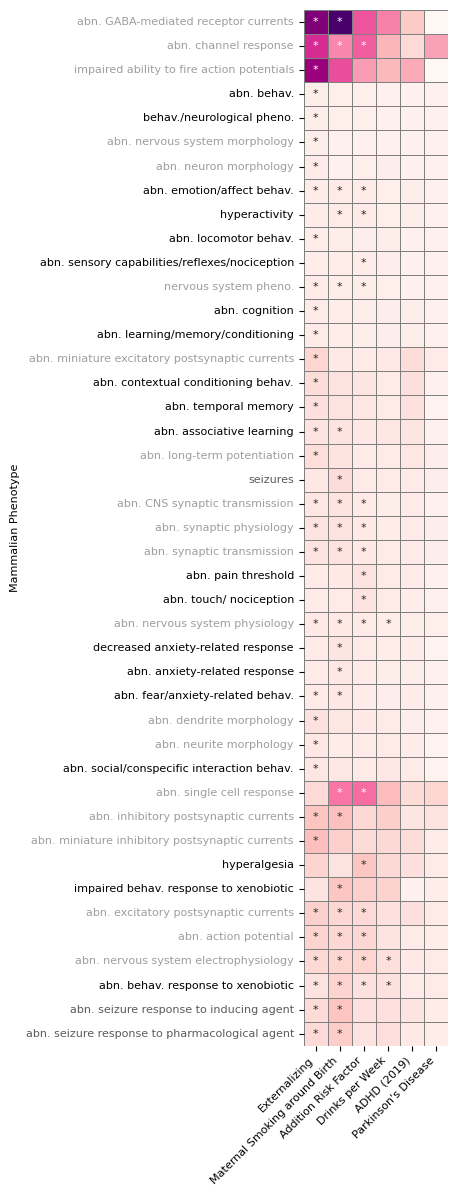

In [39]:
plt.figure(figsize=(12, 12))
ax = sns.heatmap(
    odds_c,
    annot=annot_c,
    fmt='',
    cmap=sns.color_palette("RdPu", as_cmap=True),
    linewidths=0.5,
    linecolor='gray',
    square=True,
    cbar=False
)

# Apply color to x-tick labels
for label, color in zip(ax.get_yticklabels(), ytick_colors):
    label.set_color(color)
      # Optional: make it stand out more
plt.xlabel('')
plt.ylabel('Mammalian Phenotype')

plt.xticks(rotation=45,ha='right')
plt.tight_layout()
if save_fig:
    plt.savefig('figures/MGI_val_heatmap_traits_automatic_clustering.svg')
plt.show()


# plot via MPO (loosely)

In [37]:
col_order_dict={}
for t in tbl_sub_dict.keys():
    # Subset of MP IDs
    terms = list(set(tbl_sub_dict[t]['MPO']))
    
    # Compute all pairwise shortest path lengths
    dist_matrix = pd.DataFrame(index=terms, columns=terms, dtype=float)
    for t1, t2 in combinations(terms, 2):
        try:
            dist = nx.shortest_path_length(graph, t1, t2)
        except nx.NetworkXNoPath:
            dist = float('inf')
        dist_matrix.loc[t1, t2] = dist
        dist_matrix.loc[t2, t1] = dist
        dist_matrix.loc[t1, t1] = 0
        dist_matrix.loc[t2, t2] = 0
    finite_max = dist_matrix.replace(np.inf, np.nan).max().max()
    large_distance = 2 * finite_max
    dist_matrix_fixed = dist_matrix.replace(np.inf, large_distance)
    
    # Fill diagonals with 0 if not already
    np.fill_diagonal(dist_matrix_fixed.values, 0)
    
    # Convert to condensed form
    mp_dist_condensed = squareform(dist_matrix_fixed.values)
    
    # Cluster
    linkage_matrix = linkage(mp_dist_condensed, method='ward')
    mpo_order = leaves_list(linkage_matrix)
    # Reorder columns of your original dataframe
    
    col_order = [terms[i] for i in mpo_order]
    col_order=[id_to_name[x] for x in col_order]
    
    #col_order=[x.replace(' phenotype','') for x in col_order]
    #col_order=[x.replace('abnormal ','') for x in col_order]
    col_order_dict[t]=col_order
#move highest level term to top of group
n=col_order_dict['behav'].pop(col_order_dict['behav'].index('behavior/neurological phenotype'))
col_order_dict['behav'].insert(0,n)
n=col_order_dict['nerv'].pop(col_order_dict['nerv'].index('nervous system phenotype'))
col_order_dict['nerv'].insert(0,n)

col_order=col_order_dict['behav']+col_order_dict['nerv_behav']+col_order_dict['nerv']

In [38]:
col_order=[x.replace(' phenotype',' pheno.') for x in col_order]
col_order=[x.replace('abnormal ','abn. ') for x in col_order]
col_order=[x.replace('behavioral','behav.') for x in col_order]

col_order=[x.replace('behavior','behav.') for x in col_order]


In [39]:
row_linkage = linkage(pdist(odds.values.T), method='ward')
row_order = leaves_list(row_linkage)
row_order=list(map(odds_c.T.index.__getitem__, row_order)) 

In [40]:
odds_c = odds.loc[col_order,row_order]
pval_c= pval.loc[col_order,row_order]

In [41]:
mpo_groups={
    'nerv':set(tbl_sub[(tbl_sub['trait_full'].isin(nerv_sys_traits))&(~tbl_sub['trait_full'].isin(behav_traits))]['trait']),
    'behav':set(tbl_sub[(tbl_sub['trait_full'].isin(behav_traits))&(~tbl_sub['trait_full'].isin(nerv_sys_traits))]['trait']),
    'nerv_behav':set(tbl_sub[(tbl_sub['trait_full'].isin(behav_traits))&(tbl_sub['trait_full'].isin(nerv_sys_traits))]['trait']),
    'other':set(tbl_sub[(~tbl_sub['trait_full'].isin(nerv_sys_traits))&(~tbl_sub['trait_full'].isin(behav_traits))]['trait'])
}

trait_color_map = {
    'nerv': '#9e9e9e',
    'behav': 'black',
    'nerv_behav': '#5b5b5b',
    'other': 'yellow'}

def get_trait_color(trait,trait_color_map,mpo_groups):
    for m in mpo_groups.keys():
        if trait in mpo_groups[m]:
            return trait_color_map[m]
ytick_colors = [get_trait_color(trait,trait_color_map,mpo_groups) for trait in odds_c.index]

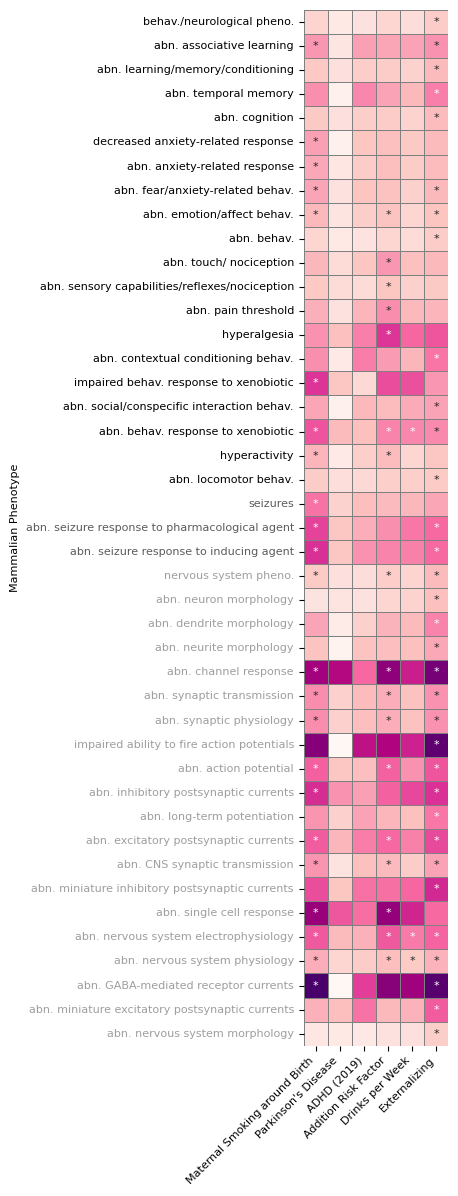

In [42]:
annot_c = pval_c.applymap(lambda p: '*' if p < sigcut else '')
plt.figure(figsize=(12, 12))
ax = sns.heatmap(
    odds_c,
    annot=annot_c,
    fmt='',
    cmap=sns.color_palette("RdPu", as_cmap=True),
    linewidths=0.5,
    linecolor='gray',
    square=True,
    cbar=False
)

# Apply color to x-tick labels
for label, color in zip(ax.get_yticklabels(), ytick_colors):
    label.set_color(color)
      # Optional: make it stand out more
plt.xlabel('')
plt.ylabel('Mammalian Phenotype')

plt.xticks(rotation=45,ha='right')
plt.tight_layout()
if save_fig:
    plt.savefig('figures/MGI_val_heatmap_traits_automatic_clustering.svg')
plt.show()

# seperate via MPO parent then clustering

In [43]:
col_linkage = linkage(pdist(odds.values.T), method='ward')
col_order = leaves_list(col_linkage)
col_order=list(map(odds.T.index.__getitem__, col_order)) 

In [45]:
row_order_dict={}
for t in tbl_sub_dict.keys():
    terms = list(set(tbl_sub_dict[t]['MPO']))
    terms=[id_to_name[x] for x in terms]
    terms=[x.replace(' phenotype',' pheno.') for x in terms]
    terms=[x.replace('abnormal ','abn. ') for x in terms]
    terms=[x.replace('behavioral','behav.') for x in terms]

    terms=[x.replace('behavior','behav.') for x in terms]

    row_linkage = linkage(pdist(odds[odds.index.isin([x for x in terms])].values), method='ward')
    mpo_order = leaves_list(row_linkage)
    
    mpo_order = [terms[i] for i in mpo_order]

    row_order_dict[t]=mpo_order
#move highest level term to top of group
n=row_order_dict['behav'].pop(row_order_dict['behav'].index('behav./neurological pheno.'))
row_order_dict['behav'].insert(0,n)
n=row_order_dict['nerv'].pop(row_order_dict['nerv'].index('nervous system pheno.'))
row_order_dict['nerv'].insert(0,n)

row_order=row_order_dict['behav']+row_order_dict['nerv_behav']+row_order_dict['nerv']

In [46]:
odds_c = odds.loc[row_order,col_order]
pval_c= pval.loc[row_order,col_order]

In [47]:
mpo_groups={
    'nerv':set(tbl_sub[(tbl_sub['trait_full'].isin(nerv_sys_traits))&(~tbl_sub['trait_full'].isin(behav_traits))]['trait']),
    'behav':set(tbl_sub[(tbl_sub['trait_full'].isin(behav_traits))&(~tbl_sub['trait_full'].isin(nerv_sys_traits))]['trait']),
    'nerv_behav':set(tbl_sub[(tbl_sub['trait_full'].isin(behav_traits))&(tbl_sub['trait_full'].isin(nerv_sys_traits))]['trait']),
    'other':set(tbl_sub[(~tbl_sub['trait_full'].isin(nerv_sys_traits))&(~tbl_sub['trait_full'].isin(behav_traits))]['trait'])
}

trait_color_map = {
    'nerv': '#9e9e9e',
    'behav': 'black',
    'nerv_behav': '#5b5b5b',
    'other': 'yellow'}

def get_trait_color(trait,trait_color_map,mpo_groups):
    for m in mpo_groups.keys():
        if trait in mpo_groups[m]:
            return trait_color_map[m]
ytick_colors = [get_trait_color(trait,trait_color_map,mpo_groups) for trait in odds_c.index]

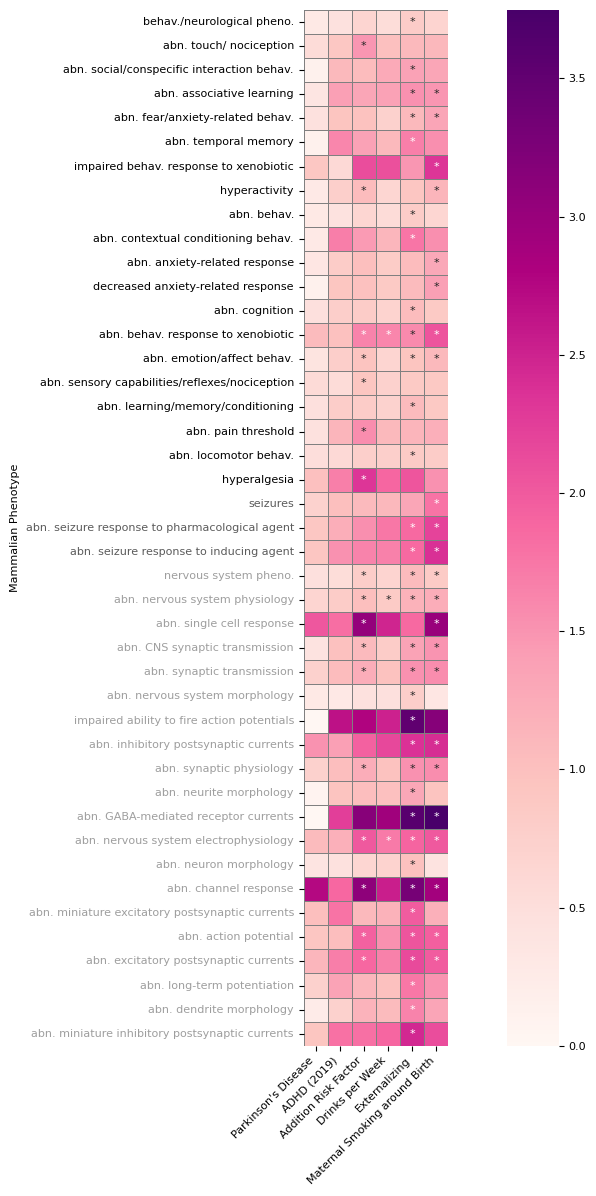

In [48]:
annot_c = pval_c.applymap(lambda p: '*' if p < sigcut else '')
plt.figure(figsize=(12, 12))
ax = sns.heatmap(
    odds_c,
    annot=annot_c,
    fmt='',
    cmap=sns.color_palette("RdPu", as_cmap=True),
    linewidths=0.5,
    linecolor='gray',
    square=True,
    cbar=True
)

# Apply color to x-tick labels
for label, color in zip(ax.get_yticklabels(), ytick_colors):
    label.set_color(color)
      # Optional: make it stand out more
plt.xlabel('')
plt.ylabel('Mammalian Phenotype')

plt.xticks(rotation=45,ha='right')
plt.tight_layout()
if save_fig:
    plt.savefig('figures/MGI_val_heatmap_traits_mpo_then_automatic_clustering.svg')
plt.show()


## landscape

In [49]:
plt.rcParams.update({'font.size': 8})

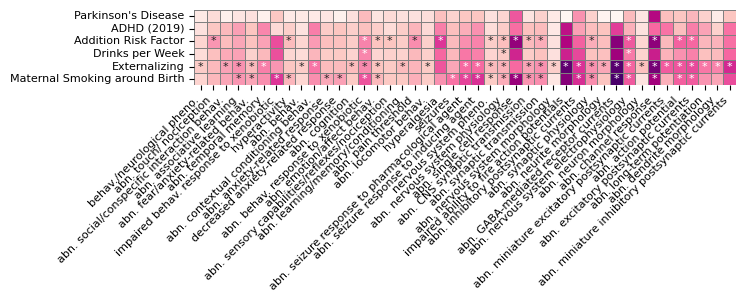

In [50]:
annot_c = pval_c.applymap(lambda p: '*' if p < sigcut else '')
plt.figure(figsize=(7.5, 7.5))
ax = sns.heatmap(
    odds_c.T,
    annot=annot_c.T,
    fmt='',
    cmap=sns.color_palette("RdPu", as_cmap=True),
    linewidths=0.5,
    linecolor='gray',
    square=True,
    cbar=False
)

# Apply color to x-tick labels
for label, color in zip(ax.get_yticklabels(), ytick_colors):
    label.set_color(color)
      # Optional: make it stand out more
plt.ylabel('')
plt.xlabel('')

plt.xticks(rotation=45,ha='right')
plt.tight_layout()
if save_fig:
    plt.savefig('figures/MGI_val_heatmap_traits_mpo_then_automatic_clustering_pivot.svg')
plt.show()


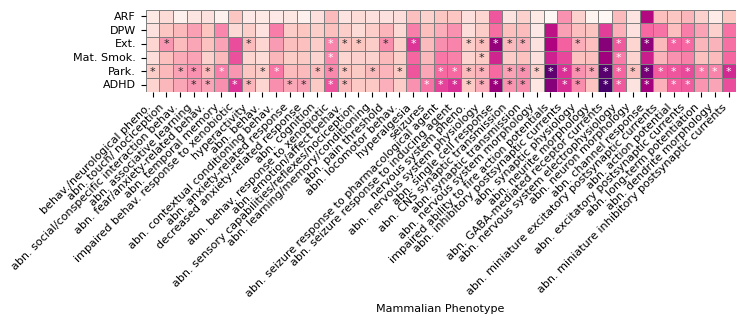

In [51]:
annot_c = pval_c.applymap(lambda p: '*' if p < sigcut else '')
plt.figure(figsize=(7.5, 7.5))
ax = sns.heatmap(
    odds_c.T,
    annot=annot_c.T,
    fmt='',
    cmap=sns.color_palette("RdPu", as_cmap=True),
    linewidths=0.5,
    linecolor='gray',
    square=True,
    cbar=False
)
ax.set_yticklabels(labels=['ARF','DPW','Ext.','Mat. Smok.',"Park.",'ADHD'])
# Apply color to x-tick labels
for label, color in zip(ax.get_yticklabels(), ytick_colors):
    label.set_color(color)
      # Optional: make it stand out more
plt.ylabel('')
plt.xlabel('Mammalian Phenotype')

plt.xticks(rotation=45,ha='right')
plt.tight_layout()
if save_fig:
    plt.savefig('figures/MGI_val_heatmap_traits_mpo_then_automatic_clustering_pivot_shorthand.svg')
plt.show()


# landscape- divided by parent trait

In [82]:
col_linkage = linkage(pdist(odds.values.T), method='ward')
col_order = leaves_list(col_linkage)
col_order=list(map(odds.T.index.__getitem__, col_order)) 

In [57]:
row_order_dict={}
for t in tbl_sub_dict.keys():
    terms = list(set(tbl_sub_dict[t]['MPO']))
    terms=[id_to_name[x] for x in terms]
    terms=[x.replace(' phenotype',' pheno.') for x in terms]
    terms=[x.replace('abnormal ','abn. ') for x in terms]
    terms=[x.replace('behavioral','behav.') for x in terms]

    terms=[x.replace('behavior','behav.') for x in terms]

    row_linkage = linkage(pdist(odds[odds.index.isin([x for x in terms])].values), method='ward')
    mpo_order = leaves_list(row_linkage)
    
    mpo_order = [terms[i] for i in mpo_order]

    row_order_dict[t]=mpo_order
#move highest level term to top of group
n=row_order_dict['behav'].pop(row_order_dict['behav'].index('behav./neurological pheno.'))
row_order_dict['behav'].insert(0,n)
n=row_order_dict['nerv'].pop(row_order_dict['nerv'].index('nervous system pheno.'))
row_order_dict['nerv'].insert(0,n)

row_order=row_order_dict['behav']+row_order_dict['nerv_behav']+row_order_dict['nerv']

In [46]:
odds_c = odds.loc[row_order,col_order]
pval_c= pval.loc[row_order,col_order]

In [47]:
mpo_groups={
    'nerv':set(tbl_sub[(tbl_sub['trait_full'].isin(nerv_sys_traits))&(~tbl_sub['trait_full'].isin(behav_traits))]['trait']),
    'behav':set(tbl_sub[(tbl_sub['trait_full'].isin(behav_traits))&(~tbl_sub['trait_full'].isin(nerv_sys_traits))]['trait']),
    'nerv_behav':set(tbl_sub[(tbl_sub['trait_full'].isin(behav_traits))&(tbl_sub['trait_full'].isin(nerv_sys_traits))]['trait']),
    'other':set(tbl_sub[(~tbl_sub['trait_full'].isin(nerv_sys_traits))&(~tbl_sub['trait_full'].isin(behav_traits))]['trait'])
}

trait_color_map = {
    'nerv': '#9e9e9e',
    'behav': 'black',
    'nerv_behav': '#5b5b5b',
    'other': 'yellow'}

def get_trait_color(trait,trait_color_map,mpo_groups):
    for m in mpo_groups.keys():
        if trait in mpo_groups[m]:
            return trait_color_map[m]
ytick_colors = [get_trait_color(trait,trait_color_map,mpo_groups) for trait in odds_c.index]

In [60]:
tbl_sub_dict.keys()

dict_keys(['nerv', 'behav', 'nerv_behav'])

In [93]:
save_fig=True

In [149]:
sub='nerv_behav'

In [150]:
odds_c = odds.loc[row_order,col_order]
pval_c= pval.loc[row_order,col_order]

pval_c=pval_c[pval_c.index.isin(mpo_groups[sub])]
odds_c=odds_c[odds_c.index.isin(mpo_groups[sub])]

In [151]:
plt.rcParams.update({'font.size': 12})

In [152]:
label

Text(0, 19.5, 'abn. miniature inhibitory postsynaptic currents')

In [153]:
odds_c.columns=["Parkinson's Disease", 'ADHD', 'Addition Risk Factor', 'Drinks per Week', 'Externalizing', 'Maternal Smoking around Birth']

pval_c.columns=["Parkinson's Disease", 'ADHD', 'Addition Risk Factor',
       'Drinks per Week', 'Externalizing', 'Maternal Smoking around Birth']

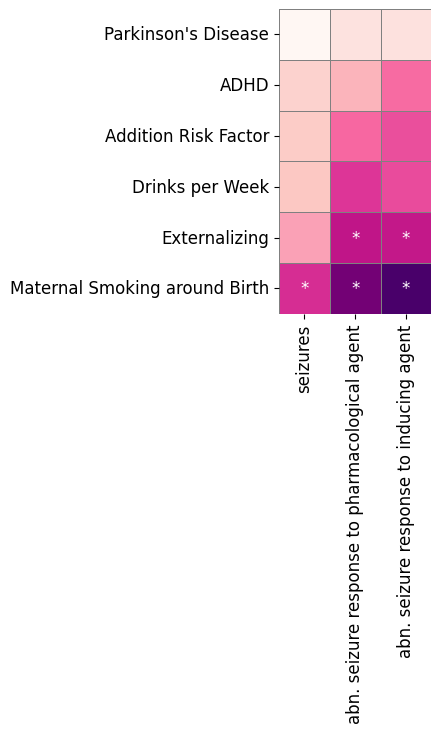

In [154]:
annot_c = pval_c.applymap(lambda p: '*' if p < sigcut else '')
plt.figure(figsize=(7.5, 7.5))

ax = sns.heatmap(
    odds_c.T,
    annot=annot_c.T,
    fmt='',
    cmap=sns.color_palette("RdPu", as_cmap=True),
    linewidths=0.5,
    linecolor='gray',
    square=True,
    cbar=False
)

# Apply color to x-tick labels
for label, color in zip(ax.get_yticklabels(), ytick_colors):
    label.set_color(color)
      # Optional: make it stand out more
plt.ylabel('')
plt.xlabel('')

plt.xticks(rotation=90,ha='center')
plt.tight_layout()
if save_fig:
    plt.savefig(f'figures/MGI_val_heatmap_traits_mpo_then_automatic_clustering_pivot_{sub}.svg')
    plt.savefig(f'figures/MGI_val_heatmap_traits_mpo_then_automatic_clustering_pivot_{sub}.png',dpi=600,bbox_inches='tight')

plt.show()


In [155]:
save_fig=True

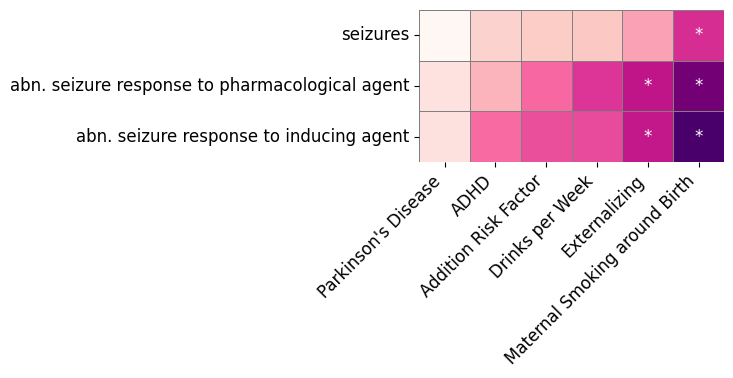

In [156]:
annot_c = pval_c.applymap(lambda p: '*' if p < sigcut else '')
plt.figure(figsize=(7.5, 7.5))

ax = sns.heatmap(
    odds_c,
    annot=annot_c,
    fmt='',
    cmap=sns.color_palette("RdPu", as_cmap=True),
    linewidths=0.5,
    linecolor='gray',
    square=True,
    cbar=False
)

# Apply color to x-tick labels
for label, color in zip(ax.get_yticklabels(), ytick_colors):
    label.set_color(color)
      # Optional: make it stand out more
plt.ylabel('')
plt.xlabel('')

plt.xticks(rotation=45,ha='right')
plt.tight_layout()
if save_fig:
    plt.savefig(f'figures/MGI_val_heatmap_traits_mpo_then_automatic_clustering_{sub}.svg')
    plt.savefig(f'figures/MGI_val_heatmap_traits_mpo_then_automatic_clustering_{sub}.png',dpi=600,bbox_inches='tight')

plt.show()
